In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [4]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [5]:
path = "/content/drive/MyDrive/Datasets/Data/Flickr8k.token.txt"
captions = readTextFile(path)
captions = captions.split("\n")[:-1]

In [6]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [7]:
 print(len(captions))

40460


In [8]:
descriptions = {}
for x in captions:
    first,second = x.split("\t")
    img_name = first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(second)

In [9]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

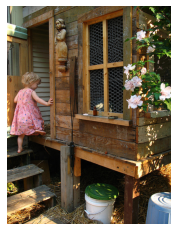

In [11]:
IMG_PATH = "/content/drive/MyDrive/Datasets/Data/Images/"

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# Data Cleaning

In [12]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [13]:
clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [14]:
for key,captions_list in descriptions.items():
    for i in range(len(captions_list)):
        captions_list[i] = clean_text(captions_list[i])

In [15]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [16]:
with open("descriptions1.txt", "w") as f:
    f.write(str(descriptions))

# Vocabulary

In [17]:
descriptions = None
with open("descriptions1.txt",'r') as f:
    descriptions = f.read()
descriptions = json.loads(descriptions.replace("'","\""))

In [18]:
type(descriptions)

dict

In [19]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab size : %d"%len(vocab))

Vocab size : 8424


In [20]:
#total words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words: %d"%len(total_words))

Total words: 373837


In [21]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [22]:
# Filter Words according to a frequency threshold
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [23]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt  if x[1] >threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [24]:
len(total_words)

1845

# Training Data

In [25]:
train_file_data = readTextFile("/content/drive/MyDrive/Datasets/Data/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/drive/MyDrive/Datasets/Data/Flickr_8k.testImages.txt")

In [29]:
train = [row.split('.')[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split('.')[0] for row in test_file_data.split("\n")[:-1]]

In [30]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [35]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [36]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# Transfer Learning
- Images, Text -> Features

# Feature Extraction

In [37]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102973440/102967424 [==============================] - 0s 0us/step


In [38]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [39]:
model_new = Model(model.input, model.layers[-2].output)

In [40]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalisation
    img = preprocess_input(img)
    return img

In [41]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


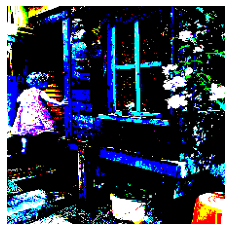

In [42]:
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [44]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(-1,)
    return feature_vector

In [46]:
encoding_train = {}
start = time()
for ix,img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    if ix%100==0:
        print(ix)
end = time()
print("Total time is: ",(end-start))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Total time is:  1966.5517177581787


In [47]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [48]:
encoding_test = {}
start = time()
for ix,img_id in enumerate(test):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_test[img_id] = encode_image(img_path)
    if ix%100==0:
        print("Test Encoding %d"%ix)
end = time()
print("Total time is: ",(end-start))

Test Encoding 0
Test Encoding 100
Test Encoding 200
Test Encoding 300
Test Encoding 400
Test Encoding 500
Test Encoding 600
Test Encoding 700
Test Encoding 800
Test Encoding 900
Total time is:  319.6345202922821


In [49]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

# Data Pre-Processing Captions

In [133]:
len(total_words)

1845

In [134]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [135]:
word_to_idx["dog"],idx_to_word[6]

(6, 'dog')

In [136]:
print(len(idx_to_word))

1845


In [137]:
idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

In [138]:
vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [139]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

In [140]:
max_len

35

In [141]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

In [142]:
f = open("/content/drive/MyDrive/Datasets/glove.6B.50d.txt",encoding="utf8")

In [143]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding_word = np.array(values[1:],dtype='float')
    embedding_index[word] = embedding_word

In [144]:
f.close()

In [145]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [146]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [147]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


# Model Architecture

In [148]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation="relu")(inp_img1)

In [149]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [150]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

In [151]:
model = Model(inputs=[input_img_features,input_captions], outputs=outputs)

In [152]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

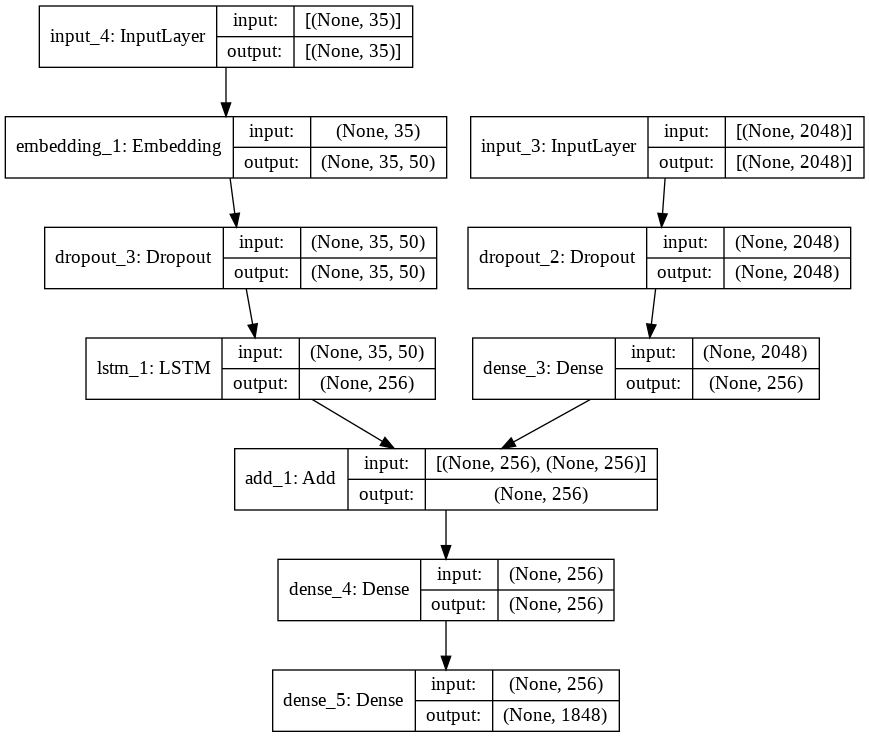

In [153]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [154]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [155]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [156]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Training of the Model

In [157]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [158]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

2000/2000 [==============================] - 31s 14ms/step - loss: 4.7710


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 28s 14ms/step - loss: 2.5718


In [159]:
for i in range(10):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,6)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

   4/2000 [..............................] - ETA: 46s - loss: 2.3611

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 42s 21ms/step - loss: 2.3529


In [164]:
model = load_model("./model_weights/model_19.h5")

# Predictions

In [161]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

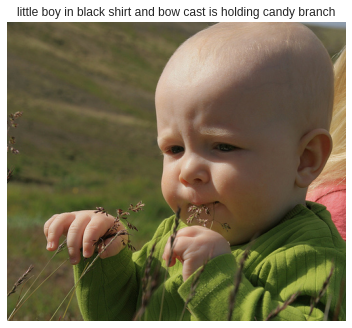

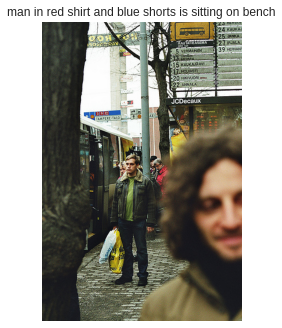

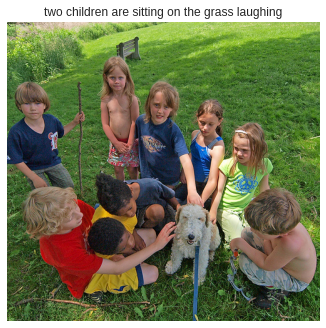

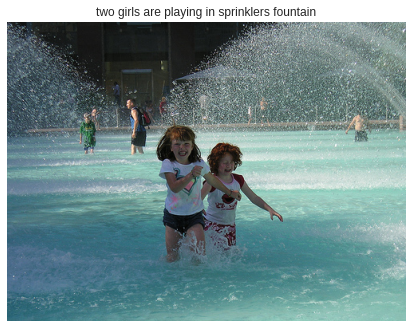

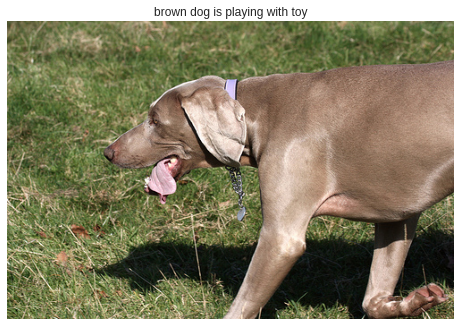

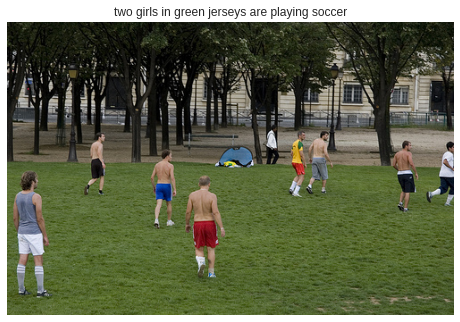

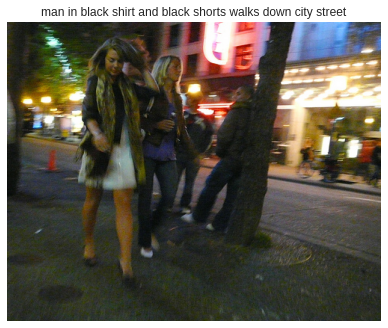

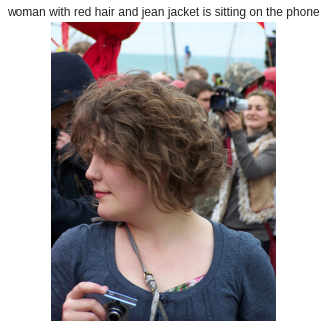

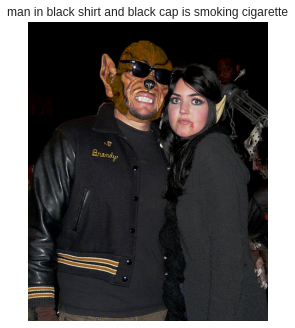

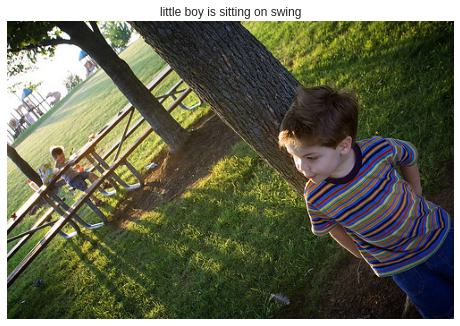

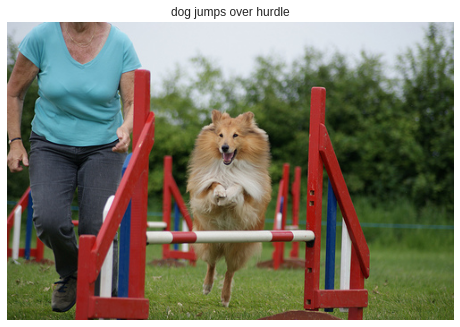

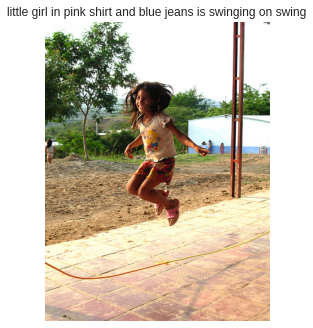

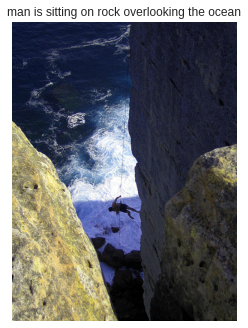

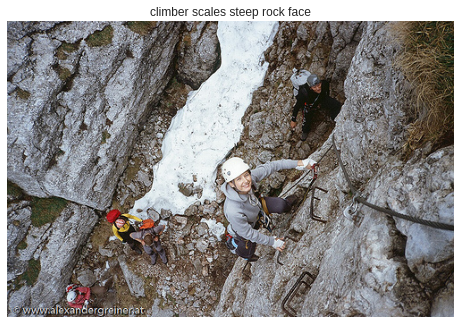

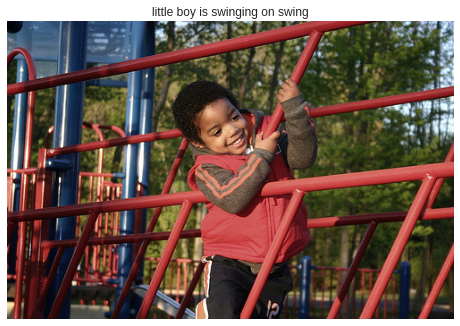

In [165]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/drive/MyDrive/Datasets/Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    